# Model Definition for Periodic Auto Encoder

## Model and Dataset definition

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.parameter import Parameter
import numpy as np
from matplotlib import pyplot as plt

class PAE(nn.Module):
    def __init__(self, input_channels, latent_channels, window_size, fps, dim=2):
        super(PAE, self).__init__()
        self.input_channels = input_channels
        self.latent_channels = latent_channels
        self.window_size = window_size
        self.duration = window_size/fps
        self.fps = fps
        self.dim = dim

        self.tpi = Parameter(torch.from_numpy(np.array([2.0*np.pi], dtype=np.float32)), requires_grad=False)
        self.freqs = Parameter(torch.fft.rfftfreq(window_size, d=1/self.fps)[1:], requires_grad=False)  # DC component is removed
        self.time = Parameter(torch.from_numpy(np.linspace(-self.duration/2, self.duration/2, int(fps * 2 + 1), dtype=np.float32)), requires_grad=False)


        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, input_channels//3, kernel_size=window_size, stride=1, padding=int((window_size - 1) / 2), bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(input_channels//3),
            nn.Tanh(),
            nn.Conv1d(input_channels//3, latent_channels, kernel_size=window_size, stride=1, padding=int((window_size - 1) / 2), bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(latent_channels),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(latent_channels, input_channels//3, kernel_size=window_size, stride=1, padding=int((window_size - 1) / 2), bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(input_channels//3),
            nn.Tanh(),
            nn.Conv1d(input_channels//3, input_channels, kernel_size=window_size, stride=1, padding=int((window_size - 1) / 2), bias=True, padding_mode='zeros'),

        )

        self.fc = torch.nn.ModuleList()
        self.bn = torch.nn.ModuleList()
        for i in range(latent_channels):
            self.fc.append(nn.Linear(window_size, 2))
            self.bn.append(nn.BatchNorm1d(2))

    def fft(self, function):
        rfft = torch.fft.rfft(function, dim=self.dim, norm="forward")
        magnitudes = rfft.abs()
        spectrum = magnitudes[:, :, 1:] #Spectrum without DC component
        power = spectrum**2

        #Frequency
        freq = torch.sum(self.freqs.view(1,1,self.freqs.shape[0]) * power, dim=self.dim) / torch.sum(power, dim=self.dim)

        #Amplitude
        amp = 2 * torch.sqrt(torch.sum(power, dim=self.dim))

        #Offset
        offset = rfft.real[:, :, 0] #DC component

        return freq, amp, offset, spectrum

    def atan2(self, y, x):
        tpi = self.tpi
        ans = torch.atan(y/x)
        ans = torch.where( (x<0) * (y>=0), ans+0.5*tpi, ans)
        ans = torch.where( (x<0) * (y<0), ans-0.5*tpi, ans)
        return ans

    def forward(self, x):
      
        encoded_L = self.encoder(x)

        # Frequency, Amplitude, Offset
        freq, amp, offset, _ = self.fft(encoded_L)
        freq = freq.unsqueeze(2)
        amp = amp.unsqueeze(2)
        offset = offset.unsqueeze(2)

        # Phase
        phase = torch.empty((encoded_L.shape[0], self.latent_channels), dtype=torch.float32, device=encoded_L.device)
        for i in range(self.latent_channels):
            v = self.fc[i](encoded_L[:,i,:])
            v = self.bn[i](v)
            phase[:,i] = self.atan2(v[:,1], v[:,0]) / self.tpi

        phase = phase.unsqueeze(2)

        periodic_L = amp * torch.sin(self.tpi * (freq * self.time + phase)) + offset

        decoded = self.decoder(periodic_L)

        return decoded, encoded_L, periodic_L, phase, freq, amp, offset


class VelocityDataset(Dataset):
    def __init__(self, file_path, window_size):
        data = np.load(file_path)
        self.data = data.reshape(data.shape[0], -1)
        self.window_size = window_size
        self.num_frames , self.num_features = self.data.shape

    def __len__(self):
        return self.num_frames - self.window_size + 1

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size, :]
        # Transposing so that the shape is (num_channels, length)
        # This shape is how the Conv1d expects the input to be i.e (batch_size, num_channels, length)
        return window.T


## Training the Model

In [3]:
import os

def train_model(model, dataloader, optimizer, scheduler, num_epochs=5, save_freq=2, 
                device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                save_path="MoTran.pth", checkpoint_path=None):
    
    # Helps point out operatoion that isn't compatible with backprop
    torch.autograd.set_detect_anomaly(True)

    # For plotting
    duration = model.window_size/model.fps
    time = np.linspace(-duration/2, duration/2, int(model.fps * 2 + 1))

    model.to(device)
    criterion = nn.MSELoss()
    start_epoch = 0

    if checkpoint_path is not None:
        if os.path.exists(checkpoint_path):
            print("Loading checkpoint...")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for inputs in dataloader:
            inputs = inputs.to(device)  # Move inputs to GPU
            
            optimizer.zero_grad()
        
            outputs, encoded_L, periodic_L, _,_,_,_ = model(inputs)
            
            loss = criterion(outputs, inputs) 
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            # add to the running loss
            running_loss += loss.item()

        
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.7f}')

        if (epoch+1) % save_freq == 0:

            # For plotting
            item = np.random.randint(0, outputs.shape[0])
            input_channel = np.random.randint(0, outputs.shape[1])

            # Plot inputs[item, input_channel] and outputs[item, input_channel] vs time
            plt.figure(figsize=(10, 5 + 2 * encoded_L.shape[1]))
            plt.subplot(encoded_L.shape[1] + 1, 1, 1)
            plt.plot(time, inputs[item, input_channel].cpu().detach().numpy(), label='Input')
            plt.plot(time, outputs[item, input_channel].cpu().detach().numpy(), label='Output')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.title(f'Epoch {epoch + 1} - Input vs Output')
            plt.legend()

            # Plot each latent channel of encoded_L and periodic_L vs time
            for latent_channel in range(encoded_L.shape[1]):
                plt.subplot(encoded_L.shape[1] + 1, 1, latent_channel + 2)
                plt.plot(time, encoded_L[item, latent_channel].cpu().detach().numpy(), label='Encoded')
                plt.plot(time, periodic_L[item, latent_channel].cpu().detach().numpy(), label='Periodic')
                plt.xlabel('Time')
                plt.ylabel(f'Latent Channel {latent_channel}')
                plt.title(f'Epoch {epoch + 1} - Latent Channel {latent_channel}')
                plt.legend()

            plt.tight_layout()
            plt.show()

            # Save checkpoint after every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, save_path)
            print(f'Checkpoint saved at epoch {epoch}')
           
    print('Training complete')
    return model

In [6]:

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_channels = 75 
latent_channels = 5 
window_size = 61
fps = 30

dataset = VelocityDataset("../data/joint_velocities.npy", window_size)
dataloader = DataLoader(dataset, 64, False)

# Create the model
model = PAE(input_channels, latent_channels, window_size, fps)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode='triangular2')

train_model(model, dataloader, optimizer, scheduler, num_epochs=42, save_freq=1, 
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
            save_path="../models/PAE.pth", checkpoint_path="../models/PAE.pth")


Loading checkpoint...
Resuming training from epoch 42
Training complete


C:\Users\mayur\AppData\Local\Temp\ipykernel_22204\2420664538.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


PAE(
  (encoder): Sequential(
    (0): Conv1d(75, 25, kernel_size=(61,), stride=(1,), padding=(30,))
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv1d(25, 5, kernel_size=(61,), stride=(1,), padding=(30,))
    (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Conv1d(5, 25, kernel_size=(61,), stride=(1,), padding=(30,))
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv1d(25, 75, kernel_size=(61,), stride=(1,), padding=(30,))
  )
  (fc): ModuleList(
    (0-4): 5 x Linear(in_features=61, out_features=2, bias=True)
  )
  (bn): ModuleList(
    (0-4): 5 x BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

## Generating phases

In [99]:
import torch
import matplotlib.pyplot as plt

checkpoint = torch.load("PAE.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

input_channels = 78 
latent_channels = 5 
window_size = 61
fps = 30

dataset = VelocityDataset(r"..\data\joint_velocities.npy", window_size)
dataloader = DataLoader(dataset, 1000, shuffle=False)

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


phases = np.empty((0, 5))
sin_manifold = np.empty((0, 5))
cos_manifold = np.empty((0, 5))


def process_data(data, padding_start=False, padding_end=False):
    if padding_start:
        padded_data = torch.zeros((data.shape[0] + window_size // 2,) + data.shape[1:])
        padded_data[window_size // 2:] = data
    if padding_end:
        padded_data = torch.zeros((data.shape[0] + window_size // 2,) + data.shape[1:])
        padded_data[:data.shape[0]] = data
    
    if padding_start == padding_end == False:
        padded_data = data

    padded_data = padded_data.to(device)
    _, _, _, phase, _, amp, _ = model(padded_data)
    phase = torch.squeeze(phase, -1)
    amp = torch.squeeze(amp, -1)
    psin = amp * torch.sin(2 * torch.pi * phase)
    pcos = amp * torch.cos(2 * torch.pi * phase)

    return psin, pcos, phase

for i, data in enumerate(dataloader):
    if i == 0:
        psin, pcos, phase = process_data(data, padding_start=True)
    elif i == len(dataloader) - 1:
        psin, pcos, phase = process_data(data, padding_end=True)
    else:
        psin, pcos, phase = process_data(data)

    sin_manifold = np.append(sin_manifold, psin.detach().cpu().numpy(), axis=0)
    cos_manifold = np.append(cos_manifold, pcos.detach().cpu().numpy(), axis=0)
    phases = np.append(phases, phase.detach().cpu().numpy(), axis=0)

phase_manifold = np.empty((phases.shape[0], 10))

phase_manifold[:, 0::2] = sin_manifold
phase_manifold[:, 1::2] = cos_manifold

np.save(r"..\data\phase_manifolds.npy",
         phase_manifold.astype(np.float32))
        
    
print(sin_manifold.shape)
print(cos_manifold.shape)
print(phases.shape)
    

C:\Users\mayur\AppData\Local\Temp\ipykernel_11556\4007426244.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("PAE.pth")


(55814, 5)
(55814, 5)
(55814, 5)


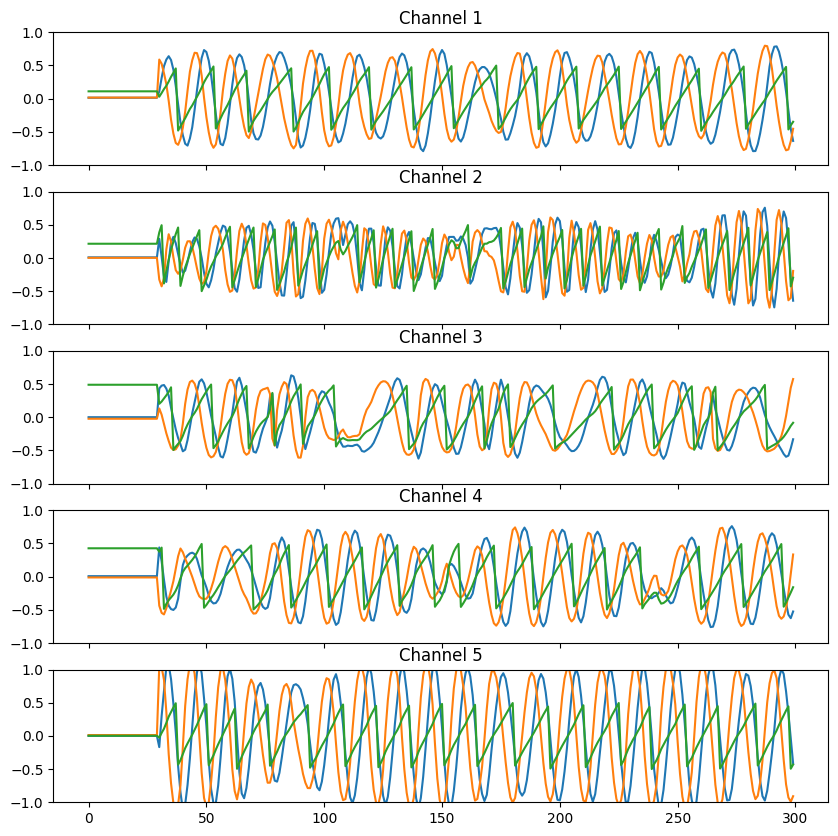

In [98]:
start = 0
size = 300

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 2*5), sharex=True)

# Plot each channel
for i in range(5):
    axes[i].plot(sin_manifold[start:start+size, i])
    axes[i].plot(cos_manifold[start:start+size, i])
    axes[i].plot(phases[start:start+size, i])
    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylim(-1, 1)
